In [27]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import segmentation_models_pytorch as smp
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst,
    Resize, ScaleIntensity, ToTensor
)
from monai.data import CacheDataset

In [32]:
DATA_ROOT = './data'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SLICE_RANGE = [145, 291]

In [ ]:



all_patients = sorted(os.listdir(DATA_ROOT))
random.seed(42)
random.shuffle(all_patients)

test_patients = all_patients[:1]
supervised_pool = all_patients[9:]

# Split supervised patients into train and val
train_patients, val_patients = train_test_split(supervised_pool, test_size=0.25, random_state=42)


print(f"Test: {test_patients}")
print(f"Train: {train_patients}")
print(f"Validation: {val_patients}")


Test: ['07040DORE']
Train: ['08002CHJE', '08027SYBR', '01038PAGU', '01016SACH']
Validation: ['01040VANE', '01042GULE']
Unsupervised: ['07040DORE', '08031SEVE', '07010NABO', '07003SATH', '08037ROGU', '08029IVDI', '07001MOEL', '01039VITE', '07043SEME', '01040VANE', '01042GULE', '08027SYBR', '01016SACH', '01038PAGU', '08002CHJE']


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    """
    Dataset PyTorch pour charger des paires image/masque depuis des dossiers de slices PNG.
    Gère les cas avec ou sans masque (pré-entraînement ou entraînement supervisé).
    Prend en compte une liste explicite de patients.
    """
    def __init__(self, root_dir, with_mask=True, resized_size=(256, 256), slice_range=None, transform=None, patient_list=None):
        self.image_paths = []
        self.mask_paths = []
        self.patient_names = []
        self.resized_size = resized_size
        self.slice_range = slice_range
        self.with_mask = with_mask
        self.transform = transform if transform is not None else transforms.ToTensor()

        # Filtrer les patients selon la liste fournie
        all_patients = sorted(os.listdir(root_dir))
        patients = patient_list if patient_list is not None else all_patients

        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder):
                continue
            if self.with_mask and not os.path.isdir(masks_folder):
                continue

            for img_file in sorted(os.listdir(images_folder)):
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue

                slice_num = int(match.group(1))
                if self.slice_range and not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                    continue

                img_path = os.path.join(images_folder, img_file)
                if self.with_mask:
                    mask_path = os.path.join(masks_folder, img_file)
                    if not os.path.exists(mask_path):
                        continue
                    self.mask_paths.append(mask_path)

                self.image_paths.append(img_path)
                self.patient_names.append(patient)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        resize = transforms.Resize(self.resized_size)
        img = resize(img)
        img = self.transform(img)
        img = (img - 0.5) / 0.5  # Normalisation [-1, 1]

        if self.with_mask:
            mask = Image.open(self.mask_paths[idx]).convert('L')
            mask = resize(mask)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()
            return img, mask, self.image_paths[idx]
        else:
            return img, self.image_paths[idx]

    def get_patient_name(self, idx):
        return self.patient_names[idx]


In [33]:
train_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=train_patients)
val_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=val_patients)
test_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=test_patients)

In [24]:
from monai.apps.mmars.model_desc import MODEL_DESC

MMAR_ID = "clara_pt_brain_mri_segmentation_1"

# Récupérer la spec via son champ "id"
spec = next(s for s in MODEL_DESC if s["id"] == MMAR_ID)
print("✅ Found spec id:", spec["id"])


✅ Found spec id: clara_pt_brain_mri_segmentation_1


In [29]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,    # ou 3 si vous dupliquez la tranche
    classes=1,
).to(DEVICE)

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


In [36]:
from torch.utils.data import DataLoader

# Hyper-paramètres pour les DataLoaders
BATCH_SIZE   = 4   # ajustez selon la VRAM disponible
NUM_WORKERS  = 0   # 0 en notebook, sinon >0 pour accélérer le chargement

# Loader d’entraînement
train_loader = DataLoader(
    train_dataset,        # PngSlicesDataset(with_mask=True)
    batch_size=BATCH_SIZE,
    shuffle=True,         # on mélange les données d’entraînement
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Loader de validation
val_loader = DataLoader(
    val_dataset,          # PngSlicesDataset(with_mask=True)
    batch_size=BATCH_SIZE,
    shuffle=False,        # pas de shuffle pour la validation
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Loader de test
test_loader = DataLoader(
    test_dataset,         # PngSlicesDataset(with_mask=True)
    batch_size=BATCH_SIZE,
    shuffle=False,        # pas de shuffle pour le test
    num_workers=NUM_WORKERS,
    pin_memory=True,
)


Val 1: 100%|██████████| 43/43 [00:14<00:00,  2.95it/s]


Epoch 1 — Train Loss: 1.0168 | Val Loss: 1.0236 | Val Dice: 0.3244
 💾 Nouveau meilleur modèle


Val 2: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]


Epoch 2 — Train Loss: 0.9172 | Val Loss: 0.8737 | Val Dice: 0.4158
 💾 Nouveau meilleur modèle


Val 3: 100%|██████████| 43/43 [00:08<00:00,  5.17it/s]


Epoch 3 — Train Loss: 0.8283 | Val Loss: 0.8363 | Val Dice: 0.3926


Val 4: 100%|██████████| 43/43 [00:09<00:00,  4.57it/s]


Epoch 4 — Train Loss: 0.7437 | Val Loss: 0.8743 | Val Dice: 0.3414


Val 5: 100%|██████████| 43/43 [00:09<00:00,  4.41it/s]


Epoch 5 — Train Loss: 0.6871 | Val Loss: 0.7226 | Val Dice: 0.4420
 💾 Nouveau meilleur modèle


Val 6: 100%|██████████| 43/43 [00:15<00:00,  2.74it/s]


Epoch 6 — Train Loss: 0.6255 | Val Loss: 0.7472 | Val Dice: 0.4162


Val 7: 100%|██████████| 43/43 [00:11<00:00,  3.71it/s]


Epoch 7 — Train Loss: 0.5908 | Val Loss: 0.7003 | Val Dice: 0.4650
 💾 Nouveau meilleur modèle


Val 8: 100%|██████████| 43/43 [00:16<00:00,  2.59it/s]


Epoch 8 — Train Loss: 0.5449 | Val Loss: 0.6961 | Val Dice: 0.4451


Val 9: 100%|██████████| 43/43 [00:06<00:00,  6.68it/s]


Epoch 9 — Train Loss: 0.4996 | Val Loss: 0.7046 | Val Dice: 0.4488


Val 10: 100%|██████████| 43/43 [00:04<00:00,  9.06it/s]


Epoch 10 — Train Loss: 0.4553 | Val Loss: 0.6812 | Val Dice: 0.4612


Val 11: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]


Epoch 11 — Train Loss: 0.4021 | Val Loss: 0.6909 | Val Dice: 0.4538


Val 12: 100%|██████████| 43/43 [00:10<00:00,  4.06it/s]


Epoch 12 — Train Loss: 0.3728 | Val Loss: 0.6769 | Val Dice: 0.4522


Val 13: 100%|██████████| 43/43 [00:14<00:00,  3.00it/s]


Epoch 13 — Train Loss: 0.3427 | Val Loss: 0.6963 | Val Dice: 0.4279


Val 14: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]


Epoch 14 — Train Loss: 0.3191 | Val Loss: 0.6529 | Val Dice: 0.4785
 💾 Nouveau meilleur modèle


Val 15: 100%|██████████| 43/43 [00:09<00:00,  4.63it/s]


Epoch 15 — Train Loss: 0.3040 | Val Loss: 0.6722 | Val Dice: 0.4515


Val 16: 100%|██████████| 43/43 [00:11<00:00,  3.66it/s]


Epoch 16 — Train Loss: 0.2841 | Val Loss: 0.6818 | Val Dice: 0.4405


Val 17: 100%|██████████| 43/43 [00:08<00:00,  5.32it/s]


Epoch 17 — Train Loss: 0.2835 | Val Loss: 0.6862 | Val Dice: 0.4317


Val 18: 100%|██████████| 43/43 [00:07<00:00,  5.39it/s]


Epoch 18 — Train Loss: 0.2743 | Val Loss: 0.6753 | Val Dice: 0.4484


Val 19: 100%|██████████| 43/43 [00:09<00:00,  4.53it/s]


Epoch 19 — Train Loss: 0.2655 | Val Loss: 0.6603 | Val Dice: 0.4660


Val 20: 100%|██████████| 43/43 [00:08<00:00,  4.93it/s]


Epoch 20 — Train Loss: 0.2601 | Val Loss: 0.6340 | Val Dice: 0.5025
 💾 Nouveau meilleur modèle


Val 21: 100%|██████████| 43/43 [00:07<00:00,  5.57it/s]


Epoch 21 — Train Loss: 0.2625 | Val Loss: 0.6902 | Val Dice: 0.4336


Val 22: 100%|██████████| 43/43 [00:10<00:00,  4.18it/s]


Epoch 22 — Train Loss: 0.2552 | Val Loss: 0.6986 | Val Dice: 0.4179


Val 23: 100%|██████████| 43/43 [00:11<00:00,  3.82it/s]


Epoch 23 — Train Loss: 0.2577 | Val Loss: 0.6777 | Val Dice: 0.4443


Val 24: 100%|██████████| 43/43 [00:07<00:00,  6.05it/s]


Epoch 24 — Train Loss: 0.2442 | Val Loss: 0.6554 | Val Dice: 0.4702


Val 25: 100%|██████████| 43/43 [00:11<00:00,  3.68it/s]


Epoch 25 — Train Loss: 0.2467 | Val Loss: 0.6909 | Val Dice: 0.4274


Val 26: 100%|██████████| 43/43 [00:08<00:00,  4.94it/s]


Epoch 26 — Train Loss: 0.2370 | Val Loss: 0.6612 | Val Dice: 0.4639


Val 27: 100%|██████████| 43/43 [00:08<00:00,  4.86it/s]


Epoch 27 — Train Loss: 0.2306 | Val Loss: 0.6885 | Val Dice: 0.4305


Val 28: 100%|██████████| 43/43 [00:09<00:00,  4.66it/s]


Epoch 28 — Train Loss: 0.2257 | Val Loss: 0.6809 | Val Dice: 0.4394


Val 29: 100%|██████████| 43/43 [00:08<00:00,  4.86it/s]


Epoch 29 — Train Loss: 0.2164 | Val Loss: 0.6789 | Val Dice: 0.4417


Val 30: 100%|██████████| 43/43 [00:08<00:00,  4.86it/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch 30 — Train Loss: 0.2131 | Val Loss: 0.6927 | Val Dice: 0.4252
 ⏹ Early stopping


Test: 100%|██████████| 26/26 [00:05<00:00,  4.54it/s]


🎯 Test Dice: 0.33330505112042796


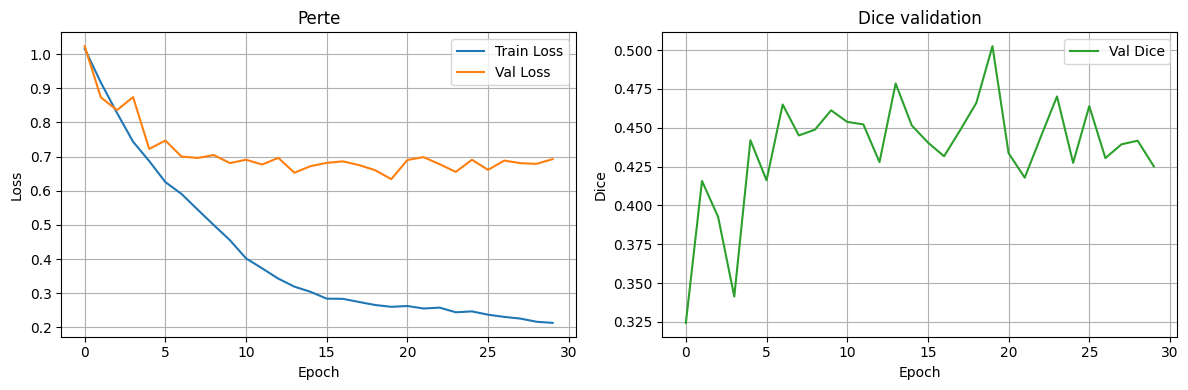

In [41]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.metrics import DiceMetric

# 1) Définition de la loss combinée Dice + BCE
dice_loss = DiceLoss(sigmoid=True)
bce_loss  = lambda logits, targets: F.binary_cross_entropy_with_logits(logits, targets)
def criterion(logits, targets):
    return dice_loss(logits, targets) + 0.3 * bce_loss(logits, targets)

# 2) Figement des deux premiers blocs de l'encodeur
#    Ajustez selon la structure de votre modèle (ici exemple SMP Unet)
for name, param in model.encoder.layer1.named_parameters():
    param.requires_grad = False
for name, param in model.encoder.layer2.named_parameters():
    param.requires_grad = False

# 3) Optimizer à learning-rate différentiel
optimizer = AdamW([
    {"params": [p for p in model.parameters() if not p.requires_grad], "lr": 1e-5},
    {"params": [p for p in model.parameters() if     p.requires_grad], "lr": 1e-4},
], weight_decay=1e-5)

scheduler   = ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5, verbose=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# 4) Initialisation de l’historique et du meilleur
history   = {"train_loss": [], "val_loss": [], "val_dice": []}
best_dice = 0.0
no_imp    = 0

# 5) Boucle de fine-tuning
for epoch in range(1, 51):
    # — Entraînement —
    model.train()
    running_train_loss = 0.0
    for imgs, masks, _ in tqdm(train_loader, desc=f"Train {epoch}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = model(imgs)
        loss   = criterion(logits, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader)
    history["train_loss"].append(train_loss)

    # — Validation —
    model.eval()
    dice_metric.reset()
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, _ in tqdm(val_loader, desc=f"Val {epoch}"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            running_val_loss += criterion(logits, masks).item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            dice_metric(y_pred=preds, y=masks)
    val_loss = running_val_loss / len(val_loader)
    val_d   = dice_metric.aggregate().item()
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_d)

    # — Scheduler & early-stopping —
    scheduler.step(val_loss)
    print(f"Epoch {epoch} — Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_d:.4f}")
    if val_d > best_dice:
        best_dice, no_imp = val_d, 0
        torch.save(model.state_dict(), "best_model.pth")
        print(" 💾 Nouveau meilleur modèle")
    else:
        no_imp += 1
        if no_imp >= 10:
            print(" ⏹ Early stopping")
            break

# 6) Évaluation finale sur le test set
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
dice_metric.reset()
scores = []
with torch.no_grad():
    for imgs, masks, _ in tqdm(test_loader, desc="Test"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = (torch.sigmoid(model(imgs)) > 0.5).float()
        dice_metric(y_pred=preds, y=masks)
        scores.append(dice_metric.aggregate().item())
        dice_metric.reset()
print("🎯 Test Dice:", np.mean(scores))

# 7) Tracé des courbes
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Perte")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history["val_dice"], label="Val Dice", color="tab:green")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.title("Dice validation")
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


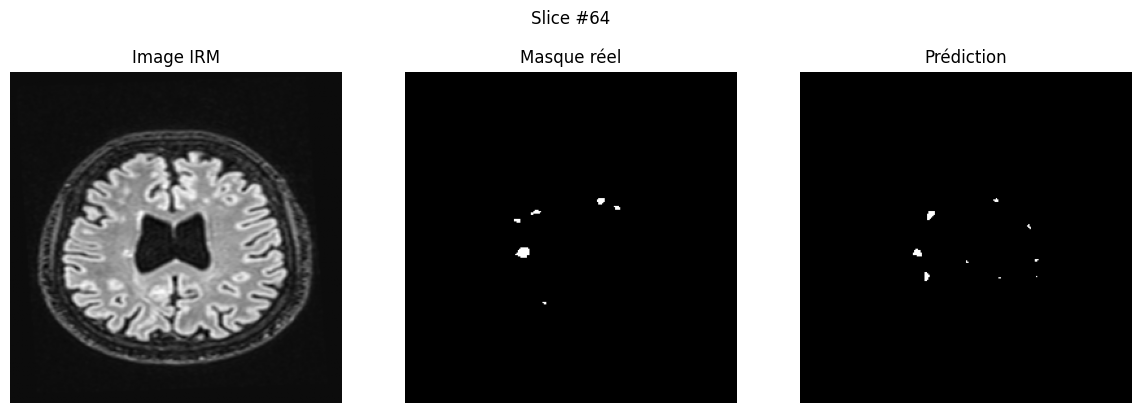

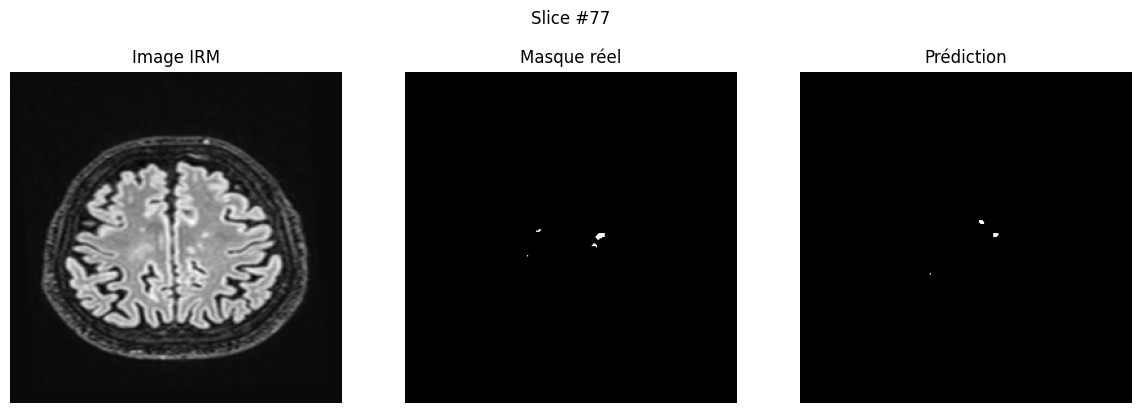

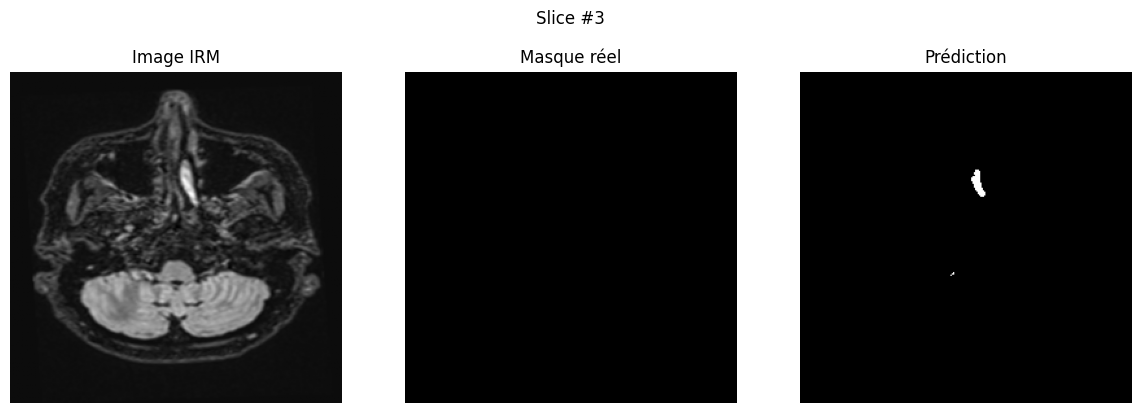

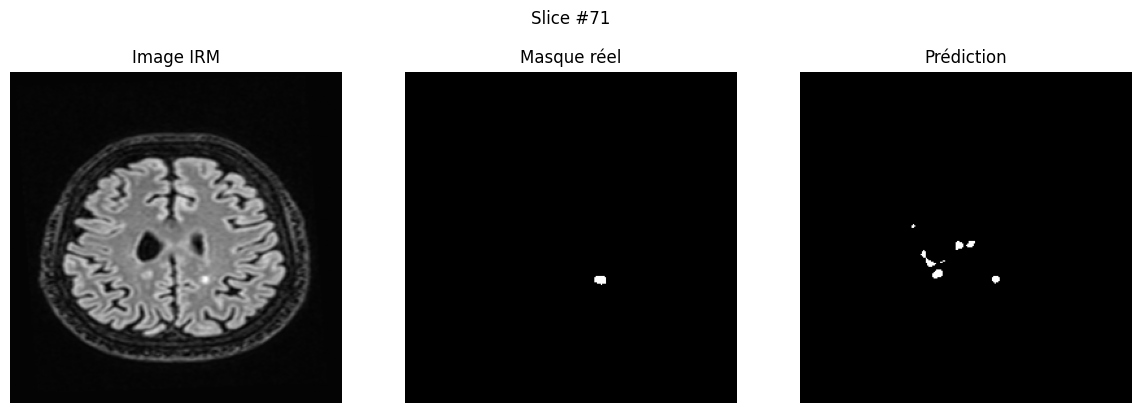

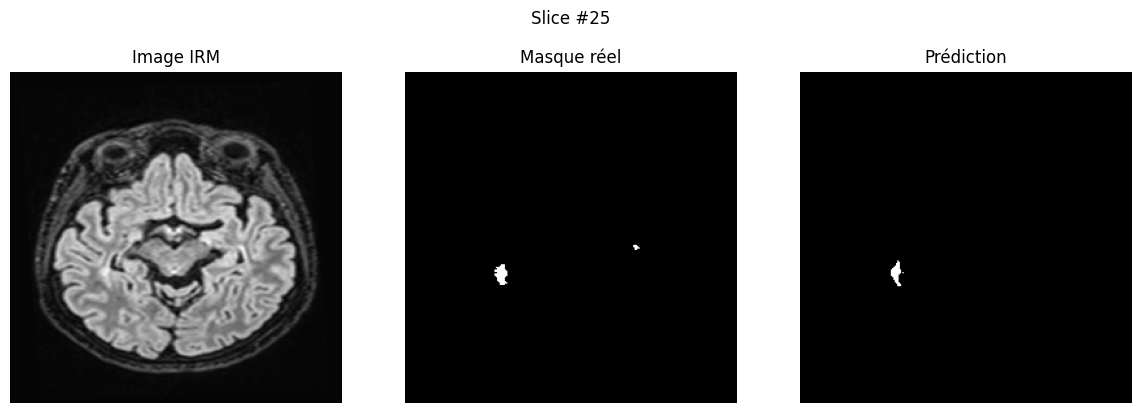

In [43]:
import random
import matplotlib.pyplot as plt

def show_random_test_slices(model, test_loader, n_samples=5):
    """
    Tire n_samples slices aléatoires depuis test_loader
    et affiche l'image, le masque et la prédiction côté-à-côté.
    """
    model.eval()
    # 1) Rassembler toutes les données de test en mémoire
    all_imgs, all_masks = [], []
    with torch.no_grad():
        for imgs, masks, _ in test_loader:
            all_imgs.append(imgs.cpu())
            all_masks.append(masks.cpu())
    all_imgs  = torch.cat(all_imgs, dim=0)   # [N,1,H,W]
    all_masks = torch.cat(all_masks, dim=0)  # [N,1,H,W]
    N = all_imgs.shape[0]

    # 2) Choisir des indices aléatoires
    indices = random.sample(range(N), k=min(n_samples, N))

    # 3) Afficher chaque slice sélectionnée
    for idx in indices:
        img = all_imgs[idx:idx+1].to(DEVICE)    # [1,1,H,W]
        msk = all_masks[idx:idx+1].to(DEVICE)   # [1,1,H,W]
        with torch.no_grad():
            logits = model(img)
            pred   = (torch.sigmoid(logits) > 0.5).float()

        # Passage en numpy pour matplotlib
        img_np  = img.cpu().squeeze().numpy()
        msk_np  = msk.cpu().squeeze().numpy()
        pred_np = pred.cpu().squeeze().numpy()

        # Affichage
        plt.figure(figsize=(12,4))
        plt.suptitle(f"Slice #{idx}", y=1.02)
        plt.subplot(1,3,1)
        plt.imshow(img_np,  cmap="gray")
        plt.title("Image IRM")
        plt.axis("off")
        plt.subplot(1,3,2)
        plt.imshow(msk_np,  cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")
        plt.subplot(1,3,3)
        plt.imshow(pred_np, cmap="gray")
        plt.title("Prédiction")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# Exemple d'appel
show_random_test_slices(model, test_loader, n_samples=5)


Compute Dice per slice: 100%|██████████| 103/103 [00:03<00:00, 29.71it/s]


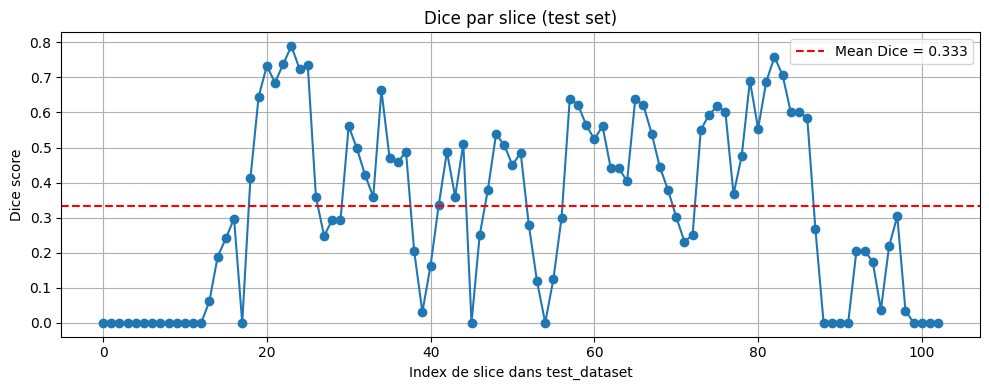

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric
from tqdm import tqdm

# 1) Calculer le Dice pour chaque slice d'après son indice dans test_dataset
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_per_slice = []

model.eval()
with torch.no_grad():
    for idx, (img, mask, _) in enumerate(tqdm(test_dataset, desc="Compute Dice per slice")):
        # img, mask sont des tensors [1,H,W] ou [C,H,W]
        input_tensor = img.unsqueeze(0).to(DEVICE)   # [1,C,H,W]
        mask_tensor  = mask.unsqueeze(0).to(DEVICE)  # [1,1,H,W]
        logits = model(input_tensor)
        pred   = (torch.sigmoid(logits) > 0.5).float()
        dice_metric.reset()
        dice_metric(y_pred=pred, y=mask_tensor)
        dice_score = dice_metric.aggregate().item()
        dice_per_slice.append(dice_score)

# 2) Tracer Dice vs slice index
plt.figure(figsize=(10,4))
plt.plot(range(len(dice_per_slice)), dice_per_slice, marker='o', linestyle='-')
plt.xlabel("Index de slice dans test_dataset")
plt.ylabel("Dice score")
plt.title("Dice par slice (test set)")
plt.grid(True)
plt.axhline(np.mean(dice_per_slice), color='r', linestyle='--',
            label=f"Mean Dice = {np.mean(dice_per_slice):.3f}")
plt.legend()
plt.tight_layout()
plt.show()
